<a href="https://colab.research.google.com/github/jonahyuan/AI-learning/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
path = "/content/drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

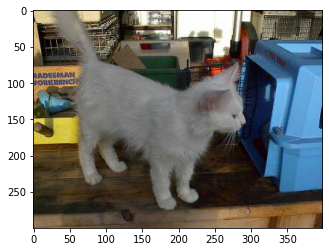

In [2]:
import glob
import matplotlib.pyplot as plt
from PIL import Image
fs = glob.glob("train/*")
plt.imshow(Image.open(fs[20]))

In [3]:
import random
import pandas as pd
dogs = glob.glob("train/dog.*")
random.shuffle(dogs)
cats = glob.glob("train/cat.*")
random.shuffle(cats)
train = pd.DataFrame({
    "path":dogs[:900] + cats[:900],
    "target":[0] * 900 + [1] * 900
})
validate = pd.DataFrame({
    "path":dogs[900:950] + cats[900:950],
    "target":[0] * 50 + [1] * 50
})
test = pd.DataFrame({
    "path":dogs[950:1000] + cats[950:1000],
    "target":[0] * 50 + [1] * 50
})

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
for l in vgg.layers:
  l.trainable = False
layers = [
          GlobalAveragePooling2D(),
          Dense(2, activation="softmax")


]
layers = vgg.layers + layers
model = Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"]       )

In [7]:
import numpy as np
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
fs = glob.glob("train/*")
target = fs[20]

# 預處理(要照你偷來的模型做)
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(target).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img))
print(img_np)

[[[ 38.060997    73.221       81.32      ]
  [ 41.060997    85.221       93.32      ]
  [ 30.060997    81.221       92.32      ]
  ...
  [ -9.939003    11.221001    46.32      ]
  [ -8.939003    13.221001    51.32      ]
  [-36.939003   -12.778999    27.32      ]]

 [[ 41.060997    76.221       84.32      ]
  [ 51.060997    94.221      102.32      ]
  [ 33.060997    84.221       95.32      ]
  ...
  [-31.939003   -11.778999    15.32      ]
  [-35.939003   -12.778999    15.32      ]
  [-51.939003   -27.779        2.3199997 ]]

 [[ 45.060997    76.221       84.32      ]
  [ 46.060997    86.221       95.32      ]
  [ 37.060997    87.221       97.32      ]
  ...
  [-29.939003    -9.778999     2.3199997 ]
  [-29.939003    -8.778999     5.3199997 ]
  [-25.939003    -3.7789993   13.32      ]]

 ...

 [[-24.939003    -6.7789993   17.32      ]
  [-20.939003    -2.7789993   21.32      ]
  [-17.939003     0.22100067  24.32      ]
  ...
  [-70.939      -69.779      -48.68      ]
  [-78.939      -7

In [8]:
import numpy as np
x_train = np.array(train["path"])
y_train = np.array(train["target"])
x_validate = np.array(validate["path"])
y_validate = np.array(validate["target"])
x_test = np.array(test["path"])
y_test = np.array(test["target"])

In [9]:

from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input
def get_data(x, y, batch=None):
    # 如果不是None, 那代表是數字(20), 隨機20個idx
    # 如果是None, 那就沒有隨機, 拿全部
    if batch is not None:
        idx = np.random.randint(0, len(x), size=batch)
        x, y = x[idx], y[idx]
    # img_pre: preprocess過後的圖片
    # img_ori: 沒有preprocess的圖片
    img_pre, img_ori = [], []
    # 走過我的每一個path
    for p in x:
        # 讀取圖片並且預處理
        img = Image.open(p).convert("RGB").resize((224, 224))
        img = np.array(img)
        img_pre.append(preprocess_input(img))
        img_ori.append(img)
    # 回傳(預處理過後圖片, 沒處理圖片, 答案)
    return (np.array(img_pre), np.array(img_ori), y)
# 使用範例
x, x_ori, y = get_data(x_train, y_train, 10)
print(x.shape)
print(x_ori.shape)
print(y.shape)
# print(x)

(10, 224, 224, 3)
(10, 224, 224, 3)
(10,)


In [10]:

# validate和test全部讀出來
xv, xv_ori, yv = get_data(x_validate, y_validate)
xt, xt_ori, yt = get_data(x_test, y_test)
print(xv.shape)
print(xt.shape)

(100, 224, 224, 3)
(100, 224, 224, 3)


In [11]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    print("-" * 15, i, "end", "-" * 15)

train: [2.8627281188964844, 0.5]
validate: [2.3672101497650146, 0.5899999737739563]
--------------- 0 end ---------------
train: [1.6191927194595337, 0.75]
validate: [2.1757261753082275, 0.6200000047683716]
--------------- 1 end ---------------
train: [2.233140468597412, 0.699999988079071]
validate: [2.0255589485168457, 0.6499999761581421]
--------------- 2 end ---------------
train: [1.2809069156646729, 0.6000000238418579]
validate: [1.8758071660995483, 0.6600000262260437]
--------------- 3 end ---------------
train: [1.4138679504394531, 0.699999988079071]
validate: [1.7432811260223389, 0.6899999976158142]
--------------- 4 end ---------------
train: [1.5445770025253296, 0.550000011920929]
validate: [1.6158088445663452, 0.7200000286102295]
--------------- 5 end ---------------
train: [1.3015340566635132, 0.6499999761581421]
validate: [1.4830939769744873, 0.7300000190734863]
--------------- 6 end ---------------
train: [1.8867807388305664, 0.6499999761581421]
validate: [1.3705815076828

In [ ]:
# 我沒有使用fit: 因為使用fit你一定要把全部圖都讀好(現實世界不太可能)
# 真的自己一步一步來: train_on_batch, test_on_batch
minloss, patience = float("inf"), 0 
for i in range(50):
    x, _, y = get_data(x_train, y_train, batch=20)
    result = model.train_on_batch(x, y)
    print("train:", result)
    result = model.test_on_batch(xv, yv)
    print("validate:", result)
    if result[0] < minloss:
        minloss, patience = result[0], 0
        model.save("xxx.h5")
    else:
        patience = patience + 1
    if patience == 5:
        break
    print("-" * 15, i, "end", "-" * 15)